In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import torch
from torch import nn, optim
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim


/data1/dataiku/DATA_DESIGNER/code-envs/python/offus/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
"""
metrics.py
Clustering evaluation metrics for algorithms that assign single labels (no meta-clusters)
-1 indicates outliers
"""

import numpy as np
from itertools import combinations
from scipy.special import comb

def Re(original_label, pred_label):
    """
    Error Rate (Re)
    
    Calculates the ratio of misclassifications to total number of objects.
    
    Definition: Re = Ne / N
    where Ne = number of misclassifications
          N  = total number of objects
    
    Misclassification occurs when:
    1. pred_label[i] != original_label[i] (wrong cluster assignment)
    2. pred_label[i] == -1 (outlier) but original_label[i] is not an outlier*
    
    *Note: Assumes original_label has no outlier class (-1)
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments (non-negative integers)
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments (-1 for outliers)
        
    Returns:
    --------
    re : float
        Error rate (0 to 1, lower is better)
    """
    n = len(original_label)
    if n == 0:
        return 0
    
    ne = 0  # Number of misclassifications
    
    for i in range(n):
        true_cluster = original_label[i]
        pred_cluster = pred_label[i]
        
        # Misclassification if:
        # 1. Wrong cluster assignment
        # 2. Predicted as outlier (-1) but true is not outlier
        if pred_cluster == -1:
            # If predicted as outlier, always misclassification 
            # (since original_label has no outlier class)
            ne += 1
        elif pred_cluster != true_cluster:
            ne += 1
    
    return ne / n

def Ri(original_label, pred_label):
    """
    Imprecision Rate (Ri)
    
    In your algorithm without meta-clusters, this should always return 0
    since there are no meta-cluster assignments.
    
    Definition: Ri = Ni / N
    where Ni = number of objects in meta-clusters
          N  = total number of objects
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments
        
    Returns:
    --------
    ri : float
        Always 0 (no meta-clusters)
    """
    return 0.0

def EP(original_label, pred_label):
    """
    Evidential Precision (EP) - Simplified for single label assignments
    
    Measures precision of non-outlier assignments.
    
    Definition: EP = TP* / (TP* + FP*)
    where TP* = number of pairs of similar objects (same true cluster) 
                that are both assigned to the same cluster (and not outliers)
          FP* = number of pairs of dissimilar objects (different true clusters)
                that are both assigned to the same cluster (and not outliers)
    
    Only considers pairs where both objects are NOT outliers (pred_label != -1)
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments (-1 for outliers)
        
    Returns:
    --------
    ep : float
        Evidential precision (0 to 1, higher is better)
    """
    n = len(original_label)
    
    # Find indices of non-outlier predictions
    non_outlier_indices = [i for i in range(n) if pred_label[i] != -1]
    
    if len(non_outlier_indices) < 2:
        return 0.0  # Need at least 2 non-outliers to compute pairs
    
    tp_star = 0  # True positive pairs (similar objects in same cluster)
    fp_star = 0  # False positive pairs (dissimilar objects in same cluster)
    
    # Consider all pairs of non-outlier objects
    for i, j in combinations(non_outlier_indices, 2):
        if i >= j:
            continue
            
        true_i = original_label[i]
        true_j = original_label[j]
        pred_i = pred_label[i]
        pred_j = pred_label[j]
        
        # Check if assigned to the same cluster
        if pred_i == pred_j:
            if true_i == true_j:
                tp_star += 1
            else:
                fp_star += 1
    
    denominator = tp_star + fp_star
    return tp_star / denominator if denominator > 0 else 0.0

def ERI(original_label, pred_label):
    """
    Evidential Rank Index (ERI) - Simplified for single label assignments
    
    Comprehensive evaluation considering both beneficial and detrimental elements.
    
    Definition: ERI = 2(TP* + TN*) / [N(N-1)]
    where TP* = number of pairs of similar objects (same true cluster) 
                that are both assigned to the same cluster (and not outliers)
          TN* = number of pairs of dissimilar objects (different true clusters)
                that are assigned to different clusters (and both not outliers)
          N   = total number of objects
    
    Only considers pairs where both objects are NOT outliers (pred_label != -1)
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments (-1 for outliers)
        
    Returns:
    --------
    eri : float
        Evidential rank index (0 to 1, higher is better)
    """
    n = len(original_label)
    
    if n < 2:
        return 0.0
    
    # Find indices of non-outlier predictions
    non_outlier_indices = [i for i in range(n) if pred_label[i] != -1]
    
    tp_star = 0  # True positive pairs
    tn_star = 0  # True negative pairs
    
    # Consider all pairs of non-outlier objects
    for i, j in combinations(non_outlier_indices, 2):
        if i >= j:
            continue
            
        true_i = original_label[i]
        true_j = original_label[j]
        pred_i = pred_label[i]
        pred_j = pred_label[j]
        
        same_true = (true_i == true_j)
        same_pred = (pred_i == pred_j)
        
        if same_true and same_pred:
            tp_star += 1
        elif (not same_true) and (not same_pred):
            tn_star += 1
    
    total_pairs = n * (n - 1)
    return 2 * (tp_star + tn_star) / total_pairs if total_pairs > 0 else 0.0

def rand_index(original_label, pred_label):
    """
    Rand Index (RI) - Standard version
    
    Measures the similarity between two data clusterings.
    
    Definition: RI = (TP + TN) / (TP + FP + FN + TN)
    where TP = number of pairs of similar objects (same true cluster) 
               that are both assigned to the same predicted cluster
          TN = number of pairs of dissimilar objects (different true clusters)
               that are assigned to different predicted clusters
          FP = number of pairs of dissimilar objects 
               that are assigned to the same predicted cluster
          FN = number of pairs of similar objects 
               that are assigned to different predicted clusters
    
    Treats -1 (outliers) as a separate cluster.
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments
        
    Returns:
    --------
    ri : float
        Rand Index (0 to 1, higher is better)
    """
    n = len(original_label)
    
    if n < 2:
        return 0.0
    
    tp = 0  # True positives
    tn = 0  # True negatives
    fp = 0  # False positives
    fn = 0  # False negatives
    
    # Consider all pairs of objects
    for i, j in combinations(range(n), 2):
        if i >= j:
            continue
            
        true_i = original_label[i]
        true_j = original_label[j]
        pred_i = pred_label[i]
        pred_j = pred_label[j]
        
        same_true = (true_i == true_j)
        same_pred = (pred_i == pred_j)
        
        if same_true and same_pred:
            tp += 1
        elif same_true and not same_pred:
            fn += 1
        elif not same_true and same_pred:
            fp += 1
        else:  # not same_true and not same_pred
            tn += 1
    
    total = tp + tn + fp + fn
    return (tp + tn) / total if total > 0 else 0.0

def adjusted_rand_index(original_label, pred_label):
    """
    Adjusted Rand Index (ARI)
    
    Adjusted for chance version of the Rand Index.
    
    Definition: ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
    where RI = Rand Index
          Expected_RI = expected value of RI under random assignment
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments
        
    Returns:
    --------
    ari : float
        Adjusted Rand Index (-1 to 1, higher is better, 0 = random)
    """
    n = len(original_label)
    
    if n < 2:
        return 0.0
    
    # Create contingency table
    true_clusters = np.unique(original_label)
    pred_clusters = np.unique(pred_label)
    
    # Create contingency matrix
    contingency = np.zeros((len(true_clusters), len(pred_clusters)), dtype=int)
    
    # Map clusters to indices
    true_to_idx = {cluster: idx for idx, cluster in enumerate(true_clusters)}
    pred_to_idx = {cluster: idx for idx, cluster in enumerate(pred_clusters)}
    
    # Fill contingency matrix
    for i in range(n):
        true_idx = true_to_idx[original_label[i]]
        pred_idx = pred_to_idx[pred_label[i]]
        contingency[true_idx, pred_idx] += 1
    
    # Calculate row and column sums
    a = contingency.sum(axis=1)  # Row sums
    b = contingency.sum(axis=0)  # Column sums
    
    # Calculate index (sum over cells of n_ij choose 2)
    index = np.sum([comb(n_ij, 2) for n_ij in contingency.flatten() if n_ij >= 2])
    
    # Calculate expected index
    sum_ai = np.sum([comb(ai, 2) for ai in a if ai >= 2])
    sum_bj = np.sum([comb(bj, 2) for bj in b if bj >= 2])
    expected_index = sum_ai * sum_bj / comb(n, 2)
    
    # Calculate max index
    max_index = (sum_ai + sum_bj) / 2
    
    # Calculate ARI
    if max_index == expected_index:
        return 0.0
    else:
        ari = (index - expected_index) / (max_index - expected_index)
        return ari

def compute_all_metrics(original_label, pred_label):
    """
    Compute all 6 clustering metrics.
    
    Parameters:
    -----------
    original_label : array-like, shape (n_samples,)
        Ground truth cluster assignments
    pred_label : array-like, shape (n_samples,)
        Predicted cluster assignments (-1 for outliers)
        
    Returns:
    --------
    metrics : dict
        Dictionary containing all metrics
    """
    metrics = {}
    
    # Evidential clustering metrics (simplified)
    metrics['Re'] = Re(original_label, pred_label)
    metrics['Ri'] = Ri(original_label, pred_label)  # Always 0
    metrics['EP'] = EP(original_label, pred_label)
    metrics['ERI'] = ERI(original_label, pred_label)
    
    # Standard clustering metrics
    metrics['RI'] = rand_index(original_label, pred_label)
    metrics['ARI'] = adjusted_rand_index(original_label, pred_label)
    
    return metrics

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
# =========================
# Masked Variational Autoencoder
# =========================

class MaskedVAE(nn.Module):
    """
    Masked Variational Autoencoder for incomplete data.
    Encoder input: [x ⊙ m , m]
    Latent output: mu (used as latent feature u_i)
    """

    def __init__(self, input_dim, hidden_dim=128, latent_dim=8):
        super().__init__()

        # Encoder: input_dim * 2 because of concatenation with mask
        self.encoder = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.1)
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x, mask):
        x_masked = x * mask
        enc_input = torch.cat([x_masked, mask], dim=1)
        h = self.encoder(enc_input)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x, mask):
        mu, logvar = self.encode(x, mask)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


# =========================
# Masked VAE Loss
# =========================

def masked_vae_loss(
    recon_x,
    x,
    mask,
    mu,
    logvar,
    recon_weight=1,
    kl_weight=0,
    eps=1e-8
):
    """
    Masked reconstruction + KL divergence loss
    """

    # Masked reconstruction loss (MSE over observed entries only)
    se = (recon_x - x) ** 2
    masked_se = se * mask
    recon_loss = masked_se.sum(dim=1) / (mask.sum(dim=1) + eps)
    recon_loss = recon_loss.mean()

    # KL divergence
    kl_loss = -0.5 * torch.mean(
        torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    )

    total_loss = recon_weight * recon_loss + kl_weight * kl_loss
    return total_loss, recon_loss.item(), kl_loss.item()


# =========================
# Training Function
# =========================

def train_masked_vae(
    model,
    dataloader,
    device,
    epochs=50,
    lr=1e-3
):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        total_rec = 0.0
        total_kl = 0.0

        for x, mask in dataloader:
            x = x.to(device).float()
            mask = mask.to(device).float()

            optimizer.zero_grad()
            recon, mu, logvar = model(x, mask)
            loss, rec, kl = masked_vae_loss(recon, x, mask, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_rec += rec
            total_kl += kl

        print(
            f"Epoch {epoch:03d} | "
            f"Loss: {total_loss:.4f} | "
            f"Recon: {total_rec:.4f} | "
        )

    return model


# =========================
# Latent Feature Extraction
# =========================

def extract_latent_features(model, X, mask, device):
    """
    Returns latent feature vectors u_i = mu_i
    """
    model.eval()
    with torch.no_grad():
        X = X.to(device).float()
        mask = mask.to(device).float()
        mu, _ = model.encode(X, mask)
    return mu.cpu()

In [7]:
# ============================================
# 1. Load  Dataset
# ============================================
from sklearn.datasets import fetch_openml
import pandas as pd

def load_uci_dataset(name, target_col=None):
    """
    Load a UCI dataset from OpenML.

    Returns
    -------
    X : np.ndarray
    y : np.ndarray
    df : pd.DataFrame (features + target)
    """
    data = fetch_openml(name=name, as_frame=True)
    df = data.frame

    if target_col is None:
        target_col = data.target.name

    X = df.drop(columns=[target_col]).values
    y = df[target_col].values

    return X, y, df


In [0]:
# How to load
_, true_labels, df = load_uci_dataset("iris")

In [7]:
# ============================================
# 2. Inject Missing Values (MCAR)
# ============================================

#Remove the target column
feature_cols = df.columns.difference(["class"])
X1 = df[feature_cols].to_numpy().astype(float)

def inject_missing_entries(X, missing_ratio, seed=42):
    """
    Entry-wise MCAR missingness.
    Guarantees ~missing_ratio fraction of ALL entries are missing.
    """
    rng = np.random.default_rng(seed)

    X_missing = X.copy()
    n, d = X_missing.shape
    total_entries = n * d
    n_missing = int(missing_ratio * total_entries)

    flat_indices = rng.choice(
        total_entries, size=n_missing, replace=False
    )

    rows = flat_indices // d
    cols = flat_indices % d

    X_missing[rows, cols] = np.nan

    return X_missing

X_missing = inject_missing_entries(X1, missing_ratio=0)

df = df.copy()
df[feature_cols] = X_missing
df=df[feature_cols]


In [8]:
# ============================================
# 3. Create Feature Matrix and Mask
# ============================================

X = df.values.astype(np.float32)

# Binary mask: 1 = observed, 0 = missing
mask = (~np.isnan(X)).astype(np.float32)

# Fill missing values with zero (mask-aware)
X_filled = np.nan_to_num(X, nan=0.0)

In [9]:
# ============================================
# 4. Mask-aware Standardization
# ============================================
class TorchScaler:
    def fit(self, X: torch.Tensor):
        self.mean = X.mean(dim=0, keepdim=True)
        self.std = X.std(dim=0, unbiased=False, keepdim=True)
        self.std[self.std == 0] = 1.0
        return self
    def transform(self, X: torch.Tensor):
        return (X - self.mean) / self.std
    def inverse_transform(self, X: torch.Tensor):
        return X * self.std + self.mean

X_scaled = X_filled.copy()
X_tensor = torch.from_numpy(np.array(X_scaled))
scaler = TorchScaler().fit(X_tensor)
X_scaled = scaler.transform(X_tensor)
mask_tensor = torch.tensor(mask, dtype=torch.float32)

In [0]:

# ============================================
# 5. PyTorch Dataset and DataLoader
# ============================================
    
class MaskedDataset:
    def __init__(self, X, mask):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.mask = torch.tensor(mask, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.mask[idx]


dataset = MaskedDataset(X_tensor, mask)
torch.manual_seed(42)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [12]:
# =========================
# Example Usage (Skeleton)
# =========================
"""
Assumes your DataLoader yields (x, mask)
x    : tensor of shape [batch_size, input_dim]
mask : tensor of shape [batch_size, input_dim], binary {0,1}
"""

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = MaskedVAE(input_dim=INPUT_DIM, latent_dim=LATENT_DIM)
# model = train_masked_vae(model, dataloader, device)
# U = extract_latent_features(model, X_full, mask_full, device)

'\nAssumes your DataLoader yields (x, mask)\nx    : tensor of shape [batch_size, input_dim]\nmask : tensor of shape [batch_size, input_dim], binary {0,1}\n'

In [0]:
vae = MaskedVAE(input_dim=4, hidden_dim=4, latent_dim=4)
vae = train_masked_vae(vae, dataloader, device,epochs=1000,lr=1e-3)

In [16]:
latent = extract_latent_features(vae, X_scaled,mask_tensor,device)
latent_np = latent.numpy()

In [18]:
#stage 2

In [81]:
import numpy as np

# ============================================================
# Stage 2: Distributional Evidential Clustering (Option 3)
# ------------------------------------------------------------
# Input  : U  -> latent features from Stage 1 (masked AE/VAE)
# Output : fuzzy memberships, hard labels, cluster parameters
#
# Key design choices (intentional):
# - Clusters are Gaussian distributions in latent space
# - Memberships are evidential (fuzzy), not probabilistic
# - Distance is negative log-likelihood (not Euclidean)
# - Explicit cluster–cluster divergence regularization
# - Diagonal covariance for stability and efficiency
# - No EM, no mixture weights, no DST
# ============================================================


# ------------------------------------------------------------
# Negative log-likelihood under a diagonal Gaussian
# This replaces point-wise Euclidean distance
# ------------------------------------------------------------
def neg_log_likelihood(u, mu, var, eps=1e-6):
    """
    u   : latent feature vector of a sample (d,)
    mu  : cluster mean (d,)
    var : diagonal variance of cluster (d,)
    """
    d = u.shape[0]
    return 0.5 * (
        np.sum(np.log(var + eps)) +
        np.sum((u - mu) ** 2 / (var + eps)) +
        d * np.log(2 * np.pi)
    )


# ------------------------------------------------------------
# KL divergence between two diagonal Gaussian clusters
# Used to explicitly penalize cluster similarity
# ------------------------------------------------------------
def kl_divergence(mu1, var1, mu2, var2, eps=1e-6):
    """
    Computes KL( N(mu1,var1) || N(mu2,var2) )
    """
    return 0.5 * np.sum(
        np.log((var2 + eps) / (var1 + eps)) +
        (var1 + (mu1 - mu2) ** 2) / (var2 + eps) - 1.0
    )


# ------------------------------------------------------------
# Initialization
# - Means initialized from random latent points
# - Variances initialized to ones
# - Memberships initialized uniformly (maximum uncertainty)
# ------------------------------------------------------------
def initialize_clusters(U, n_clusters, seed=42):
    np.random.seed(seed)
    n, d = U.shape

    idx = np.random.choice(n, n_clusters, replace=False)
    mu = U[idx].copy()
    var = np.ones((n_clusters, d))           # diagonal covariance
    M = np.ones((n, n_clusters)) / n_clusters

    return mu, var, M


# ------------------------------------------------------------
# Compute divergence penalty for each cluster
# Δ_j = sum_{k≠j} KL(C_j || C_k)
# ------------------------------------------------------------
def compute_cluster_penalties(mu, var):
    c = mu.shape[0]
    Delta = np.zeros(c)

    for j in range(c):
        for k in range(c):
            if j != k:
                Delta[j] += kl_divergence(
                    mu[j], var[j],
                    mu[k], var[k]
                )
    return Delta


# ------------------------------------------------------------
# Membership update (Option 3)
# Implements Eq. (4) in the paper
# Uses direct exponentiation (no logsumexp)
# ------------------------------------------------------------
def update_memberships(U, mu, var, beta, gamma, eps=1e-12):
    """
    Memberships are updated using likelihood + divergence cost.
    This is NOT a posterior probability (unlike GMM).
    """
    n, _ = U.shape
    c = mu.shape[0]

    Delta = compute_cluster_penalties(mu, var)
    M = np.zeros((n, c))

    for i in range(n):
        numerators = np.zeros(c)

        for j in range(c):
            # Combined cost:
            # data-to-cluster fit + cluster-separation penalty
            cost_ij = (
                neg_log_likelihood(U[i], mu[j], var[j])
                + gamma * Delta[j]
            )

            numerators[j] = np.exp(-cost_ij / (beta - 1.0))

        # Normalize memberships to sum to 1
        M[i, :] = numerators / (np.sum(numerators) + eps)

    return M


# ------------------------------------------------------------
# Cluster parameter update
# Weighted maximum likelihood using evidential memberships
# Implements Eq. (5) and Eq. (6)
# ------------------------------------------------------------
def update_clusters(U, M, beta, eps=1e-8):
    n, d = U.shape
    c = M.shape[1]

    mu_new = np.zeros((c, d))
    var_new = np.zeros((c, d))
    M_beta = M ** beta

    for j in range(c):
        w = M_beta[:, j][:, None]
        denom = np.sum(w) + eps

        # Mean update
        mu_new[j] = np.sum(w * U, axis=0) / denom

        # Diagonal covariance update
        var_new[j] = np.sum(
            w * (U - mu_new[j]) ** 2, axis=0
        ) / denom

    return mu_new, var_new


# ------------------------------------------------------------
# Main optimization loop (Algorithm 1 in paper)
# ------------------------------------------------------------
def distributional_evidential_clustering(
    U,
    n_clusters,
    beta=2.0,
    gamma=0.05,
    max_iter=3,
    tol=1e-4,
    seed=42):
    """
    Performs distributional evidential clustering on latent features.
    """
    mu, var, M = initialize_clusters(U, n_clusters, seed)

    for it in range(max_iter):
        mu_old = mu.copy()
        var_old=var.copy()
        # Step 1: update memberships
        M = update_memberships(U, mu, var, beta, gamma)

        # Step 2: update cluster distributions
        mu, var = update_clusters(U, M, beta)

        # Convergence check on cluster means
        shift = np.max(np.linalg.norm(mu - mu_old, axis=1))
        shift1 = np.max(kl_divergence(mu,var,mu_old,var_old))
        if shift < tol:
            print(f"Converged at iteration {it}")
            break

    labels = np.argmax(M, axis=1)

    return {
        "memberships": M,
        "labels": labels,
        "mu": mu,
        "var": var
    }


In [76]:
latent_np.shape

(150, 4)

In [82]:

result = distributional_evidential_clustering(
    latent_np,
    n_clusters=3,
    beta=2,
    gamma=0,
    max_iter=500,
    tol=1e-16,
    seed=42
)

In [85]:
pred_labels = result["labels"]

In [86]:
from sklearn.metrics import adjusted_rand_score


ari = compute_all_metrics(true_labels, pred_labels)
print(ari)

{'Re': 0.7466666666666667, 'Ri': 0.0, 'EP': 0.8272847682119205, 'ERI': 0.8922595078299776, 'RI': 0.8922595078299776, 'ARI': 0.7576057289555466}


In [27]:
def missing_latent_value(p):
    # How to load
    _, true_labels, df = load_uci_dataset("iris")
    X_missing = inject_missing_entries(X1, missing_ratio=0)

    df = df.copy()
    df[feature_cols] = X_missing
    df=df[feature_cols]

    X = df.values.astype(np.float32)

    # Binary mask: 1 = observed, 0 = missing
    mask = (~np.isnan(X)).astype(np.float32)

    # Fill missing values with zero (mask-aware)
    X_filled = np.nan_to_num(X, nan=0.0)
    X_scaled = X_filled.copy()
    X_tensor = torch.from_numpy(np.array(X_scaled))
    scaler = TorchScaler().fit(X_tensor)
    X_scaled = scaler.transform(X_tensor)
    mask_tensor = torch.tensor(mask, dtype=torch.float32)
    dataset = MaskedDataset(X_tensor, mask)
    torch.manual_seed(42)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    vae = MaskedVAE(input_dim=4, hidden_dim=4, latent_dim=4)
    vae = train_masked_vae(vae, dataloader, device,epochs=1000,lr=1e-3)
    latent = extract_latent_features(vae, X_scaled,mask_tensor,device)
    latent_np = latent.numpy()
    
    return df, latent_np

In [28]:
def storing_results(p):
    missing_rate=p
    data, U = missing_latent_value(missing_rate)
    result = distributional_evidential_clustering(U,n_clusters=3,beta=2,gamma=0,max_iter=500,tol=1e-8,seed=42)
    labels = result["labels"]
    data["pred"]=labels
    return compute_all_metrics(data["target"], data["pred"])

In [0]:
incomplete_rate=list(np.arange(0.01,1.01, 0.01))
iris_results=pd.DataFrame()
for i in incomplete_rate:
    data = {"incomplete_rate":i} | storing_results(i)
    data=pd.DataFrame([data])
    iris_results=pd.concat([iris_results, data], ignore_index=True)

In [30]:
res=pd.concat([pd.DataFrame([{"incomplete_rate":0.00} | ari]),iris_results])

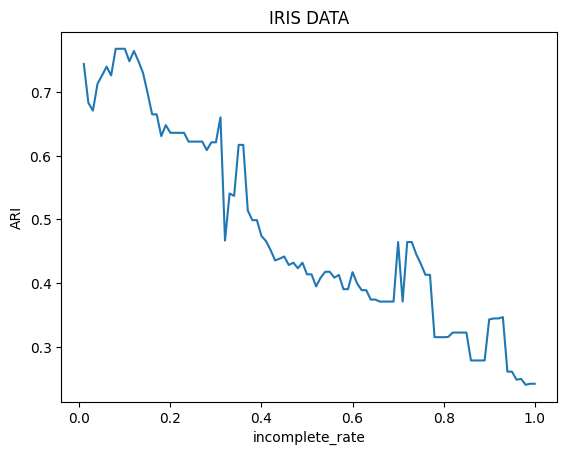

In [33]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example DataFrame
df = iris_results

# Line plot
sns.lineplot(data=df, x='incomplete_rate', y='ARI')
plt.title("IRIS DATA")
plt.show()